# Structure-Based Drug Discovery

## Aim of this lab

To understand the use and role of structure-based drug discovoery.

### Objectives

* Prep ER Alpha receptor and crystalized ligand for docking
* Download _in vitro_ binding assay data and dock using SMINA


## Background


Background on QSAR

### Descriptors

Similar to calculating chemical similiarity, PCA can be done on any set of descriptors or fingerprints.  However, just like we saw before its important to standardize if your descriptors are not already on the same range.  

We will perform docking on the estrogen receptor alpha protein. [https://www.nature.com/articles/s41598-019-43768-5](This) paper describes the crystal structures of two crystal structures submitted to the protein data bank.

1) 3ERT is human ERa-LBD with OHT, an active metabolite of TM.  
2) 1GWR is ERa-LBD with $E_{2}$.

We will use the crystal structure from `3ERT` to dock.  The receptor and the crystalized ligand have been broken up into two seperate pdb files using the program [PyMol](https://pymol.org/2/). 

In [1]:
import py3Dmol

with open("data/3ERT-receptor.pdb") as ifile:
    system = "".join([x for x in ifile])
    
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole


%pylab inline
IPythonConsole.ipython_3d = True

mol = AllChem.MolFromPDBFile("data/3ERT-OHT.pdb")
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)

mb = Chem.MolToMolBlock(mol)
p = py3Dmol.view(width=400,height=400)
p.addModel(mb,'sdf')
p.setStyle({'stick':{}})
p.setBackgroundColor('white')
p.zoomTo()
p.show()

Populating the interactive namespace from numpy and matplotlib


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Prepare ligand and receptor

The SMINA program requires pdb formats to be converted to a file format called `pdbqt`.  We can convert this using openbabel.

In [3]:
!obabel "data/3ERT-receptor.pdb" -xr -O "data/3ERT-receptor.pdbqt"

1 molecule converted


In [4]:
!obabel "data/3ERT-OHT.pdb" -O "data/3ERT-OHT.pdbqt"

1 molecule converted


## Re-Dock Crystalized Ligand with SMINA

Here we will take the co-crystalized ligand with the receptor and perform docking.  We save the results as and sdf which stores each of the top scoring conformations.  We define the box to try the conformational sampling using the crystalized ligand coordinates. 

In [5]:
!smina -r "data/3ERT-receptor.pdbqt" -l "data/3ERT-OHT.pdbqt" --autobox_ligand "data/3ERT-OHT.pdbqt" --autobox_add 8 --exhaustiveness 16 -o "data/3ERT-OHT-redock.sdf"

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -2129885392

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------

[CHEMBL831072](https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL831072/) measures binding affinity against the ER Alpha receptor, so we can get some compounds to try docking from there.

In [7]:
from rdkit.Chem import PandasTools 

redock = PandasTools.LoadSDF("data/3ERT-OHT-redock.sdf")

,minimizedAffinity,ID,ROMol
0,-9.73164082,,
1,-8.90001965,,
2,-8.64211559,,

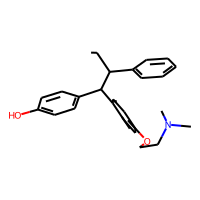
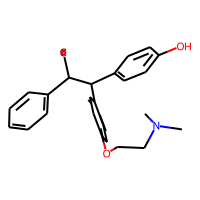
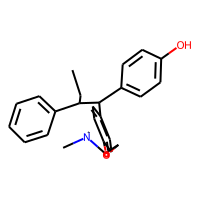

In [8]:
redock.head(3)

In [9]:
def DrawDocking(protein, ligand, crystal_ligand):
    complex_pl = Chem.MolToPDBBlock(protein)
    docked_pdb = Chem.MolToPDBBlock(ligand)
    cry_lig_pdb = Chem.MolToPDBBlock(crystal_ligand)
     
    viewer = py3Dmol.view(width=800,height=800)
    
    viewer.addModel(docked_pdb)

    viewer.zoomTo(0)
    viewer.addModel(cry_lig_pdb)

    viewer.addModel(complex_pl, 'pdb')
    prot = {'resn': ["DMS", "UNL", "SO4", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
    viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Color by secondary structure
    Lig_373 = {'resn' : 'OHT'} #original ligand in pdb file
    MyLig = {'resn':'UNL'} #ligand to be added from docking
    viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
    viewer.setStyle(Lig_373, {'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
    viewer.setStyle(MyLig, {'stick':{'colorscheme' : 'greenCarbon'}})
    
    return viewer  

### Compare Re-Dock

Here we compare the redocked pose with the original crystalized ligand.

In [11]:
mol = AllChem.MolFromPDBFile("data/3ERT-OHT.pdb")
mols = redock.ROMol.tolist()

receptor = Chem.MolFromPDBFile('data/3ERT-full.pdb')
DrawDocking(receptor, mols[0], mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Docking Binding Assays from ChEMBl

Here we download binding assay data from a ChEMBL assay ([CHEMBL831072](https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL831072/)) with _in vitro_ binding assay data against the ER alpha receptor.  We take the 5 compoounds by IC$_{50}$ value.  We use RDKit to generate conformers for them and perform docking.  We the again can compare these stuctures to the originally co-crysdtalized ligand.

In [104]:
from chembl_webresource_client.new_client import new_client

# Inhibitory activity against epidermal growth factor receptor

chembl_id = "CHEMBL831072"

overview = new_client.assay.get(chembl_id)

# print assay overview
overview


{'assay_category': None,
 'assay_cell_type': None,
 'assay_chembl_id': 'CHEMBL831072',
 'assay_classifications': [],
 'assay_organism': 'Homo sapiens',
 'assay_parameters': [],
 'assay_strain': None,
 'assay_subcellular_fraction': None,
 'assay_tax_id': 9606,
 'assay_test_type': None,
 'assay_tissue': None,
 'assay_type': 'B',
 'assay_type_description': 'Binding',
 'bao_format': 'BAO_0000357',
 'bao_label': 'single protein format',
 'cell_chembl_id': None,
 'confidence_description': 'Direct single protein target assigned',
 'confidence_score': 9,
 'description': 'Binding potency for human ER alpha',
 'document_chembl_id': 'CHEMBL1137199',
 'relationship_description': 'Direct protein target assigned',
 'relationship_type': 'D',
 'src_assay_id': None,
 'src_id': 1,
 'target_chembl_id': 'CHEMBL206',
 'tissue_chembl_id': None,
 'variant_sequence': None}

In [105]:
records = new_client.activity.filter(assay_chembl_id=chembl_id)

len(records), records[0]

(17,
 {'activity_comment': None,
  'activity_id': 1442237,
  'activity_properties': [],
  'assay_chembl_id': 'CHEMBL831072',
  'assay_description': 'Binding potency for human ER alpha',
  'assay_type': 'B',
  'assay_variant_accession': None,
  'assay_variant_mutation': None,
  'bao_endpoint': 'BAO_0000190',
  'bao_format': 'BAO_0000357',
  'bao_label': 'single protein format',
  'canonical_smiles': 'Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCCCC3)cc2)cc1',
  'data_validity_comment': None,
  'data_validity_description': None,
  'document_chembl_id': 'CHEMBL1137199',
  'document_journal': 'Bioorg. Med. Chem. Lett.',
  'document_year': 2004,
  'ligand_efficiency': {'bei': '19.62',
   'le': '0.38',
   'lle': '3.17',
   'sei': '14.63'},
  'molecule_chembl_id': 'CHEMBL304552',
  'molecule_pref_name': None,
  'parent_molecule_chembl_id': 'CHEMBL304552',
  'pchembl_value': '9.10',
  'potential_duplicate': True,
  'qudt_units': 'http://www.openphacts.org/units/Nanomolar',
  'record_id': 37309

In [106]:
import pandas as pd
data = pd.DataFrame(records)
data['value'] = data['value'].astype(float)
data.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1442237,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,0.8
1,None,1442529,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,16.0
2,None,1442535,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,2.0
3,None,1442541,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,1.8
4,None,1442940,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,2.2


In [110]:
data.columns

Index(['activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

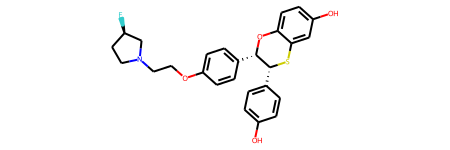

In [111]:
top_5 = data.sort_values('value')[['molecule_chembl_id', 'canonical_smiles','value', 'type', 'units']].iloc[:5]
rdkitmols = [Chem.MolFromSmiles(cmp) for cmp in top_5.canonical_smiles]
rdkitmols[0]

Assign ChEMBL IDs as names

In [113]:
for i, mol in enumerate(rdkitmols):
    mol.SetProp('Name', '{}'.format(top_5.iloc[i].molecule_chembl_id))

In [114]:
rdkitmols[0].GetProp('Name')

'CHEMBL184679'

### Generate conformers

We next generate conformations, this uses paralellisation code from http://www.rdkit.org/docs/Cookbook.html contributed by Andrew Dalke. It is based off the knowledge-based torision generator described [here](http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654).

In [126]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures


numcores = multiprocessing.cpu_count()
max_workers = numcores

# knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# this function is called in the subprocess.
# the parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh = 0.5
ps.numThreads = 0
# edit for number of confs desired eg n = 5
n = 2
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids = AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name


writer = Chem.SDWriter('data/conformers.sdf')

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for i, mol in enumerate(rdkitmols):
        if mol:
            name = mol.GetProp('Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    for job in futures.as_completed(jobs):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

In [127]:
conformers = PandasTools.LoadSDF('data/conformers.sdf')
for chembl_id, confs in conformers.groupby('ID'):
    print(chembl_id, f"has {len(confs)} conformers.")

CHEMBL135 has 1 conformers.
CHEMBL184679 has 2 conformers.
CHEMBL185114 has 2 conformers.
CHEMBL304552 has 2 conformers.
CHEMBL362718 has 2 conformers.


### Dock Conformers

In [128]:
!'smina' --cpu 2 --seed 0 -r "data/3ERT-receptor.pdbqt" -l "data/conformers.sdf" --autobox_ligand "data/3ERT-OHT.pdbqt" --autobox_add 8 --exhaustiveness 16 -o "data/chembl-redock.sdf"

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

In [129]:
from rdkit.Chem import PandasTools

docked_df = PandasTools.LoadSDF("data/chembl-redock.sdf", molColName='Molecule', removeHs=False)

In [137]:
PandasTools.WriteSDF(docked_df.sort_values('minimizedAffinity'), 'data/selectedpose.sdf', molColName="Molecule", idName="ID", properties=list(docked_df.columns))

In [138]:
!obabel  -isdf 'data/selectedpose.sdf'  -osdf   -h  -O 'data/selectedposeH.sdf'

81 molecules converted


,minimizedAffinity,ID,Molecule
0,-10.53452,CHEMBL304552,
1,-10.55528,CHEMBL184679,
2,-10.57395,CHEMBL304552,
3,-10.71821,CHEMBL184679,
4,-10.86568,CHEMBL304552,

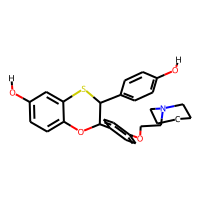
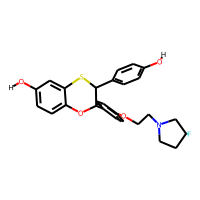
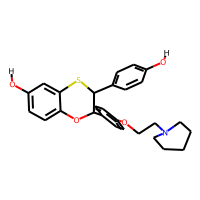
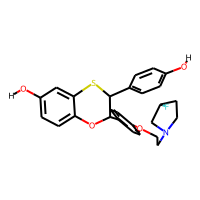
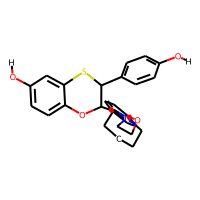

In [140]:
selecteddocked_df = PandasTools.LoadSDF('data/selectedpose.sdf', molColName='Molecule', removeHs=False)
selecteddocked_df.head(5)

Select ranked pose to visualized.  Change the value of rank to visualize the best docking poses starting from 1.

In [156]:
RANK = 81


mol = AllChem.MolFromPDBFile("data/3ERT-OHT.pdb")
mols = selecteddocked_df.Molecule.tolist()

receptor = Chem.MolFromPDBFile('data/3ERT-full.pdb')
DrawDocking(receptor, mols[RANK-1], mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol